In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

## Reading and Extracting data from .csv files

In [21]:
train_tweets = pd.read_csv('train_tweets.csv')
test_tweets = pd.read_csv('test_tweets.csv')

In [22]:
train_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [23]:
test_tweets.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## Exploratory Data Analysis

/home/shital/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


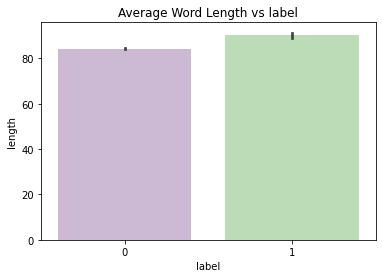

In [24]:
train_tweets['length'] = train_tweets['tweet'].apply(len)
fig1 = sns.barplot('label','length',data = train_tweets,palette='PRGn')
plt.title('Average Word Length vs label')
plot = fig1.get_figure()
plot.savefig('Barplot.png')

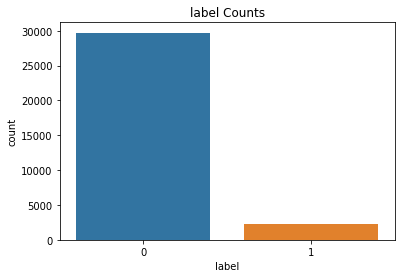

In [25]:
fig2 = sns.countplot(x= 'label',data = train_tweets)
plt.title('label Counts')
plot = fig2.get_figure()
plot.savefig('Count Plot.png')

In [26]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [27]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/shital/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shital/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/shital/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
train_tweets['tweet_list'] = train_tweets['tweet'].apply(text_processing)
test_tweets['tweet_list'] = test_tweets['tweet'].apply(text_processing)

In [29]:
train_tweets[train_tweets['label']==1].drop('tweet',axis=1).head()

,id,label,length,tweet_list
13,14,1,74,"[cnn, call, michigan, middle, school, wall, ch..."
14,15,1,101,"[comment, australia, opkillingbay, seashepherd..."
17,18,1,22,"[retweet, agree]"
23,24,1,47,"[lumpy, say, prove, lumpy]"
34,35,1,104,"[unbelievable, century, need, something, like,..."


In [30]:
X = train_tweets['tweet']
y = train_tweets['label']
test = test_tweets['tweet']

In [31]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(train_tweets['tweet'], train_tweets['label'], test_size=0.2)

In [32]:
#Machine Learning Pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_processing at 0x7fa315f7e1f0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [33]:
predictions = pipeline.predict(msg_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6327
           1       0.15      1.00      0.26        66

    accuracy                           0.94      6393
   macro avg       0.57      0.97      0.61      6393
weighted avg       0.99      0.94      0.96      6393



[[5944  383]
 [   0   66]]
0.9400907242296261


Text(0.5, 15.0, 'Predicted values')

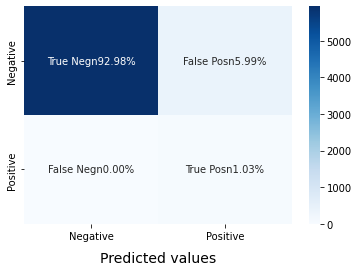

In [34]:
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(predictions,label_test)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)

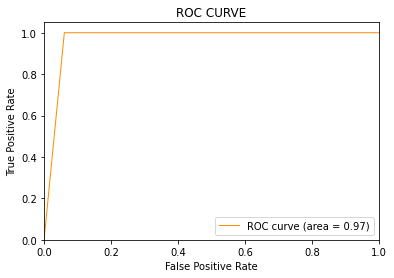

In [35]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(predictions,label_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()